## Coutour Based Coin Detection and Segmentation

In [11]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def segment_and_count_coins(image_path, display_steps=False):
    img = cv2.imread(image_path)
    if img is None:
        raise FileNotFoundError(f"Image file '{image_path}' not found.")

    original_img = img.copy()
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (11, 11), 0)

    if display_steps:
        plt.imshow(blurred, cmap='gray')
        plt.title("Blurred Image")
        plt.show()

    circles = cv2.HoughCircles(
        blurred,
        cv2.HOUGH_GRADIENT,
        dp=1.2,
        minDist=30,
        param1=50,
        param2=25,
        minRadius=15,
        maxRadius=50
    )

    if circles is not None:
        circles = np.round(circles[0, :]).astype("int")
        circles = remove_overlapping_circles(circles)

        num_coins = len(circles)

        for (x, y, r) in circles:
            cv2.circle(original_img, (x, y), r, (0, 255, 0), 2)
            cv2.circle(original_img, (x, y), 2, (0, 0, 255), 3)

    else:
        num_coins = 0
        print("No circles detected.")

    cv2.putText(
        original_img,
        f"Number of coins: {num_coins}",
        (10, 30),
        cv2.FONT_HERSHEY_SIMPLEX,
        1,
        (255, 0, 0),
        2
    )

    output_image = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(10, 8))
    plt.imshow(output_image)
    plt.title("Detected Coins")
    plt.axis('off')
    plt.show()

    return num_coins, output_image

def remove_overlapping_circles(circles):
    """
    Remove overlapping circles based on their proximity and size.
    """
    filtered_circles = []
    for circle in circles:
        x, y, r = circle
        if all(np.sqrt((x - xc) ** 2 + (y - yc) ** 2) > rc for xc, yc, rc in filtered_circles):
            filtered_circles.append((x, y, r))
    return filtered_circles

def display_image(image, title="Image", cmap_type=None):
    plt.figure(figsize=(10, 8))
    if cmap_type:
        plt.imshow(image, cmap=cmap_type)
    else:
        plt.imshow(image)
    plt.title(title)
    plt.axis('off')
    plt.show()


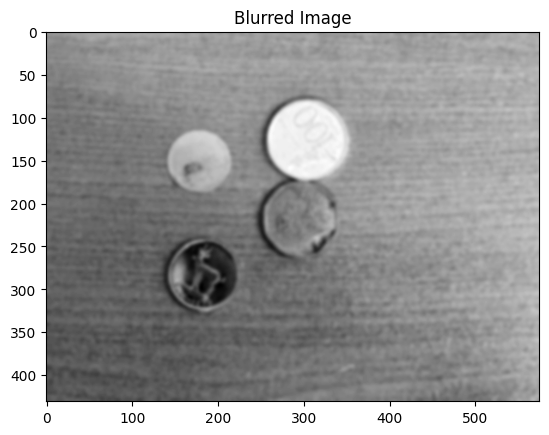

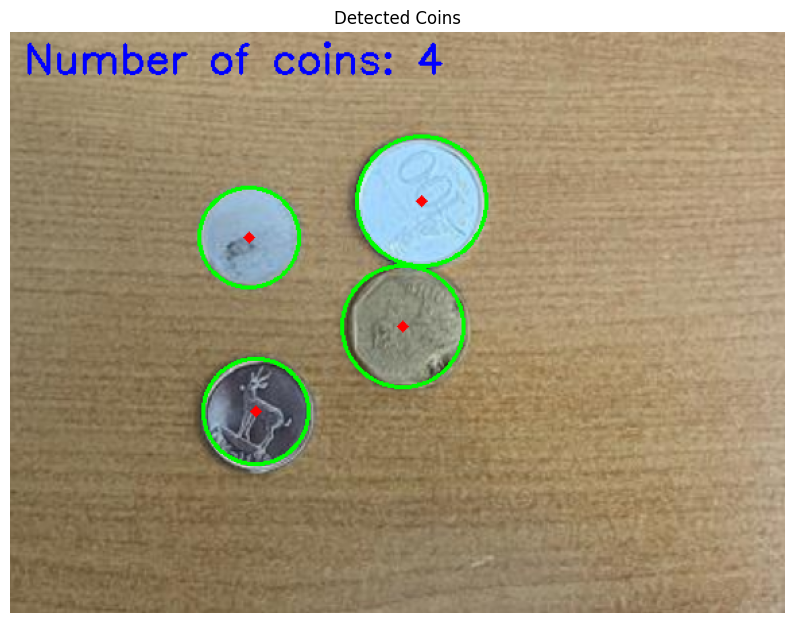

In [12]:
# Example usage
image_path = "Test Image.png"  # Replace with your image path
num_coins, output_image = segment_and_count_coins(image_path, display_steps=True)



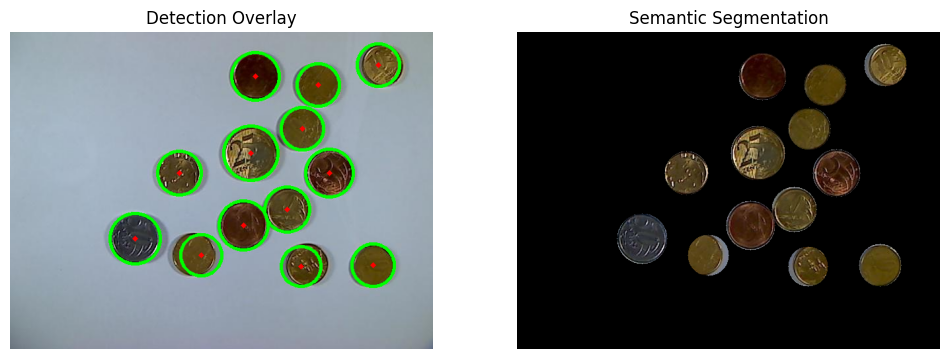

In [20]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def segment_and_count_coins(image_path, display_steps=False):
    img = cv2.imread(image_path)
    if img is None:
        raise FileNotFoundError(f"Image file '{image_path}' not found.")

    original_img = img.copy()
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (11, 11), 0)

    circles = cv2.HoughCircles(
        blurred,
        cv2.HOUGH_GRADIENT,
        dp=1.2,
        minDist=30,
        param1=50,
        param2=30,
        minRadius=20,
        maxRadius=50
    )

    # Create an empty black image for semantic segmentation
    semantic_img = np.zeros_like(original_img)
    overlay_img = original_img.copy()

    if circles is not None:
        circles = np.round(circles[0, :]).astype("int")

        for (x, y, r) in circles:
            # Draw green circles on the overlay image
            cv2.circle(overlay_img, (x, y), r, (0, 255, 0), 4)
            cv2.circle(overlay_img, (x, y), 2, (0, 0, 255), 3)  # center point

            # Create a mask for each coin
            mask = np.zeros_like(gray)
            cv2.circle(mask, (x, y), r, 255, -1)
            masked_coin = cv2.bitwise_and(original_img, original_img, mask=mask)
            # Copy the masked coin to the black background
            semantic_img[mask == 255] = masked_coin[mask == 255]
    else:
        print("No circles detected.")

    if display_steps:
        display_images(overlay_img, semantic_img)

    return overlay_img, semantic_img

def display_images(overlay_img, semantic_img):
    # Convert BGR to RGB for displaying using matplotlib
    overlay_image_rgb = cv2.cvtColor(overlay_img, cv2.COLOR_BGR2RGB)
    semantic_image_rgb = cv2.cvtColor(semantic_img, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.imshow(overlay_image_rgb)
    plt.title("Detection Overlay")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(semantic_image_rgb)
    plt.title("Semantic Segmentation")
    plt.axis('off')

    plt.show()



# Example usage
image_path = "test.jpg"  # Replace with your image path
num_coins, output_image = segment_and_count_coins(image_path, display_steps=True)



## Watershed Based Detection and Segmentation of Coins

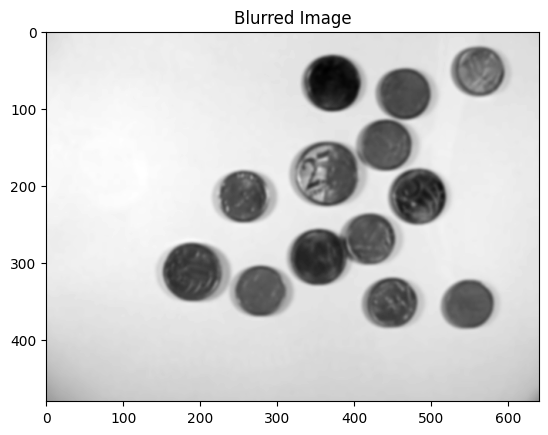

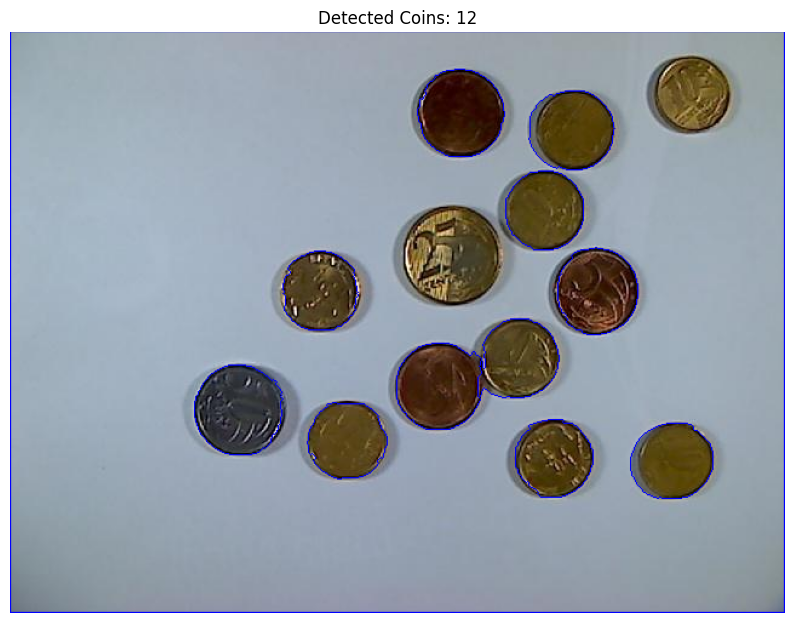

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def segment_and_count_coins_watershed(image_path, display_steps=False):
    img = cv2.imread(image_path)
    if img is None:
        raise FileNotFoundError(f"Image file '{image_path}' not found.")

    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Noise removal with a Gaussian blur
    blurred = cv2.GaussianBlur(gray, (11, 11), 0)

    if display_steps:
        plt.imshow(blurred, cmap='gray')
        plt.title("Blurred Image")
        plt.show()

    # Binary threshold
    ret, thresh = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    # Noise removal using Morphology (Opening)
    kernel = np.ones((3, 3), np.uint8)
    opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)

    # Sure background area (Dilation)
    sure_bg = cv2.dilate(opening, kernel, iterations=3)

    # Finding sure foreground area (Distance Transform)
    dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
    ret, sure_fg = cv2.threshold(dist_transform, 0.7 * dist_transform.max(), 255, 0)

    # Finding unknown region
    sure_fg = np.uint8(sure_fg)
    unknown = cv2.subtract(sure_bg, sure_fg)

    # Marker labelling
    ret, markers = cv2.connectedComponents(sure_fg)

    # Add one to all labels so that sure background is not 0, but 1
    markers = markers + 1

    # Mark the region of unknown with zero
    markers[unknown == 255] = 0

    # Apply Watershed
    markers = cv2.watershed(img, markers)
    img[markers == -1] = [255, 0, 0]  # boundary marking in red

    # Count coins
    unique_markers = np.unique(markers)
    num_coins = len(unique_markers) - 1  # subtract 1 to exclude background

    # Convert BGR to RGB for displaying using matplotlib
    output_image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(10, 8))
    plt.imshow(output_image)
    plt.title(f"Detected Coins: {num_coins}")
    plt.axis('off')
    plt.show()

    return num_coins, output_image

# Usage example, assuming the image file is at the specified path
num_coins, output_image = segment_and_count_coins_watershed('test.jpg', display_steps=True)


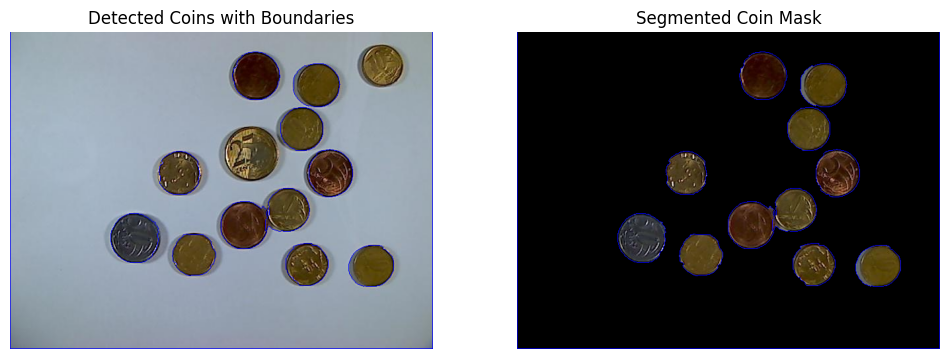

In [8]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def segment_and_count_coins_watershed(image_path, display_steps=False):
    img = cv2.imread(image_path)
    if img is None:
        raise FileNotFoundError(f"Image file '{image_path}' not found.")

    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Noise removal with a Gaussian blur
    blurred = cv2.GaussianBlur(gray, (11, 11), 0)

    # Binary threshold
    ret, thresh = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    # Noise removal using Morphology (Opening)
    kernel = np.ones((3, 3), np.uint8)
    opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)

    # Sure background area (Dilation)
    sure_bg = cv2.dilate(opening, kernel, iterations=3)

    # Finding sure foreground area (Distance Transform)
    dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
    ret, sure_fg = cv2.threshold(dist_transform, 0.7 * dist_transform.max(), 255, 0)

    # Finding unknown region
    sure_fg = np.uint8(sure_fg)
    unknown = cv2.subtract(sure_bg, sure_fg)

    # Marker labelling
    ret, markers = cv2.connectedComponents(sure_fg)

    # Add one to all labels so that sure background is not 0, but 1
    markers = markers + 1

    # Mark the region of unknown with zero
    markers[unknown == 255] = 0

    # Apply Watershed
    markers = cv2.watershed(img, markers)
    img[markers == -1] = [255, 0, 0]  # boundary marking in red

    # Create a mask for the coins
    segmented_mask = np.zeros_like(img)
    for mark in np.unique(markers):
        if mark == 0 or mark == 1:
            continue  # Background or border
        mask = np.where(markers == mark, 255, 0).astype('uint8')
        coin = cv2.bitwise_and(img, img, mask=mask)
        segmented_mask[mask == 255] = coin[mask == 255]

    # Convert BGR to RGB for displaying using matplotlib
    original_image_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    segmented_mask_rgb = cv2.cvtColor(segmented_mask, cv2.COLOR_BGR2RGB)

    if display_steps:
        display_images(original_image_rgb, segmented_mask_rgb)

    return original_image_rgb, segmented_mask_rgb

def display_images(original_img, segmented_img):
    plt.figure(figsize=(12, 6))
    plt.subplot(121)
    plt.imshow(original_img)
    plt.title("Detected Coins with Boundaries")
    plt.axis('off')

    plt.subplot(122)
    plt.imshow(segmented_img)
    plt.title("Segmented Coin Mask")
    plt.axis('off')

    plt.show()

# Usage example, assuming the image file is at the specified path
original_image, segmented_mask = segment_and_count_coins_watershed('test.jpg', display_steps=True)


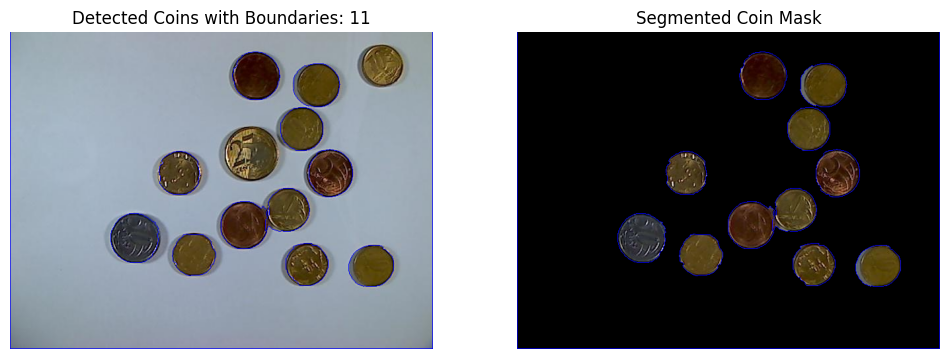

In [9]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def segment_and_count_coins_watershed(image_path, display_steps=False):
    img = cv2.imread(image_path)
    if img is None:
        raise FileNotFoundError(f"Image file '{image_path}' not found.")

    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Noise removal with a Gaussian blur
    blurred = cv2.GaussianBlur(gray, (11, 11), 0)

    # Binary threshold
    ret, thresh = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    # Noise removal using Morphology (Opening)
    kernel = np.ones((3, 3), np.uint8)
    opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)

    # Sure background area (Dilation)
    sure_bg = cv2.dilate(opening, kernel, iterations=3)

    # Finding sure foreground area (Distance Transform)
    dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
    ret, sure_fg = cv2.threshold(dist_transform, 0.7 * dist_transform.max(), 255, 0)

    # Finding unknown region
    sure_fg = np.uint8(sure_fg)
    unknown = cv2.subtract(sure_bg, sure_fg)

    # Marker labeling
    ret, markers = cv2.connectedComponents(sure_fg)

    # Add one to all labels so that sure background is not 0, but 1
    markers = markers + 1

    # Mark the region of unknown with zero
    markers[unknown == 255] = 0

    # Apply Watershed
    markers = cv2.watershed(img, markers)
    img[markers == -1] = [255, 0, 0]  # boundary marking in red

    # Count coins
    unique_markers = np.unique(markers)
    num_coins = len(unique_markers) - 2  # subtract 2 to exclude background and borders

    # Create a mask for the coins
    segmented_mask = np.zeros_like(img)
    for mark in np.unique(markers):
        if mark == 0 or mark == 1:
            continue  # Background or border
        mask = np.where(markers == mark, 255, 0).astype('uint8')
        coin = cv2.bitwise_and(img, img, mask=mask)
        segmented_mask[mask == 255] = coin[mask == 255]

    # Convert BGR to RGB for displaying using matplotlib
    original_image_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    segmented_mask_rgb = cv2.cvtColor(segmented_mask, cv2.COLOR_BGR2RGB)

    if display_steps:
        display_images(original_image_rgb, segmented_mask_rgb, num_coins)

    return num_coins, original_image_rgb, segmented_mask_rgb

def display_images(original_img, segmented_img, num_coins):
    plt.figure(figsize=(12, 6))
    plt.subplot(121)
    plt.imshow(original_img)
    plt.title(f"Detected Coins with Boundaries: {num_coins}")
    plt.axis('off')

    plt.subplot(122)
    plt.imshow(segmented_img)
    plt.title("Segmented Coin Mask")
    plt.axis('off')

    plt.show()

# Usage example, assuming the image file is at the specified path
num_coins, output_image, segmented_mask = segment_and_count_coins_watershed('test.jpg', display_steps=True)
